# Perturbation Analysis

Can INFFT enforce constraints while still staying close to target function? 
In other words, if our target function slightly violates the constraints, does the result from the INFFT still come close to approximating it?

In [1]:
from qsppack import nlfa

from matplotlib import pyplot as plt
import numpy as np
from numpy.polynomial import chebyshev as cheb
from scipy.signal import fftconvolve

## Get coeffs for Cheb approx of target function that violates constraints slightly

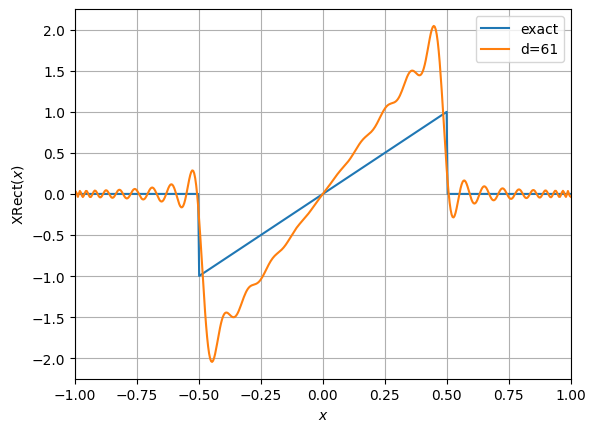

In [19]:
def f(x):
    if x < -1/2:
        return 0
    elif x >= -1/2 and x <= 1/2:
        return 2*x
    else:
        return 0
def f_vec(x):
    return np.array([f(xval) for xval in x])

x = np.linspace(-1, 1, 500)
y = f_vec(x)
degree = 61
coeffs = cheb.chebinterpolate(f_vec, degree)
coeffs[::2] = np.zeros(len(coeffs)//2) # enforce odd constraint
coeffs = coeffs * 2

# format and show
plt.grid()
plt.plot(x, y, label="exact")
plt.plot(x, cheb.chebval(x, coeffs), label=f"d={degree}")
plt.xlim(-1, 1)
plt.xlabel(r"$x$")
plt.ylabel(r"XRect$(x)$")
plt.legend()
plt.show()

## Apply INFFT and then NFFT

In [37]:
def inverse_nonlinear_FFT(a: np.ndarray, b: np.ndarray) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    Computes the inverse nonlinear FFT of a and b.

    Parameters
    ----------
    a : np.ndarray
        Input array a of length n.
    b : np.ndarray
        Input array b of length n.

    Returns
    -------
    tuple of np.ndarray
        A tuple containing gammas, xi_n, and eta_n.
    
    Examples
    --------
    >>> inverse_nonlinear_FFT(np.array([0.1, -0.5, -0.6]), np.array([0.2, -0.5, 0.3]))[0]
    array([2., 1., 3.])
    """
    n = len(a)

    # Step 1: base case
    if n == 1:
        gammas = np.array([b[0]/a[0]])
        eta_1 = np.array([1 / np.sqrt(1 + np.abs(gammas[0])**2)])
        xi_1 = gammas * eta_1
        return gammas, xi_1, eta_1
    
    # Step 2: first recursive call
    m = int(np.ceil(n/2))
    gammas = np.zeros(n, dtype=np.complex128)
    gammas[:m], xi_m, eta_m = inverse_nonlinear_FFT(a[:m], b[:m])

    # Step 3: compute coefficients of am and bm
    eta_m_sharp = np.append(0, eta_m[::-1])
    xi_m_sharp = np.append(0, xi_m[::-1])
    am = (fftconvolve(eta_m_sharp, a) + fftconvolve(xi_m_sharp, b))[m:]
    bm = (fftconvolve(eta_m, b) - fftconvolve(xi_m, a))[m:]

    # Step 4: second recursive call
    gammas[m:], xi_mn, eta_mn = inverse_nonlinear_FFT(am[:n-m], bm[:n-m])

    # Step 5: final calculation and output
    xi_n = fftconvolve(eta_m_sharp, xi_mn) + np.append(fftconvolve(xi_m, eta_mn), 0)
    eta_n = np.append(fftconvolve(eta_m, eta_mn), 0) - fftconvolve(xi_m_sharp, xi_mn)
    return gammas, xi_n, eta_n


def forward_nonlinear_FFT(gammas: np.ndarray, m=0, debug=False) -> tuple[np.ndarray, np.ndarray]:
    """
    Computes the forward nonlinear FFT, producing the polynomials a^* and b
    from the rotation parameters gammas.

    Parameters
    ----------
    gammas : np.ndarray
        Array of complex rotation parameters gamma_k of length n.
    m : int, optional
        starting index of gammas to use in the recursion.

    Returns
    -------
    tuple of np.ndarray
        A tuple (a_star, b) of length n+1 and n respectively, where a_star
        is the conjugate polynomial coefficients of a^*(z), and b is b(z).
    """
    n = len(gammas)

    # base case
    if n <= 2:
        prefactor = 1 / np.sqrt(1 + np.abs(gammas[0])**2)
        if n == 2:
            prefactor /= np.sqrt(1 + np.abs(gammas[1])**2)
        if debug:
            prefactor = 1
        b = prefactor * np.append(np.zeros(m, dtype=np.complex128), gammas)
        a_star = prefactor * np.array([1, -np.conj(gammas[0])*gammas[1]]) if n == 2 else np.array([prefactor])
        return a_star, b
    
    # recursive step
    m_new = int(np.ceil(n/2))
    if debug:
        print("m={}, n={}".format(m, n))
    a_star_left, b_left = forward_nonlinear_FFT(gammas[:m_new], debug=debug)
    a_star_right, b_right = forward_nonlinear_FFT(gammas[m_new:], m_new, debug=debug)
    
    # compute the convolution of the left and right parts
    if debug:
        print("a_star_left: ", a_star_left)
        print("b_left: ", b_left)
        print("a_star_right: ", a_star_right)
        print("b_right: ", b_right)
        print("b1: ", fftconvolve(np.conj(a_star_left[::-1]), b_right))
        print("b2: ", fftconvolve(a_star_right, b_left))
    b1 = fftconvolve(np.conj(a_star_left[::-1]), b_right)
    b1 = b1[len(a_star_left)-1:]
    b2 = fftconvolve(a_star_right, b_left)
    b2 = np.append(b2, np.zeros(len(b1)-len(b2), dtype=np.complex128))
    a_star1 = -fftconvolve(np.conj(b_left[::-1]), b_right)
    a_star1 = a_star1[len(b_left)-1:]
    a_star2 = fftconvolve(a_star_left, a_star_right)
    a_star2 = np.append(a_star2, np.zeros(len(a_star1)-len(a_star2), dtype=np.complex128))
    b = b1 + b2
    a_star = a_star1 + a_star2

    return a_star, np.append(np.zeros(m, dtype=np.complex128), b)

In [30]:
bcoeffs = nlfa.b_from_cheb(coeffs[1::2], 1)
acoeffs = nlfa.weiss(bcoeffs, 2**6)
gammas, _, _ = inverse_nonlinear_FFT(acoeffs, bcoeffs)
print(f"gammas: {gammas}")
new_a, new_b = forward_nonlinear_FFT(gammas)

gammas: [-0.02945459+0.00920064j  0.00344959-0.0149004j   0.0270541 -0.00362799j
 -0.02947103+0.03060085j  0.00068635-0.03547522j  0.02866855+0.006305j
 -0.02521242+0.03403082j -0.01103002-0.04714947j  0.04392258+0.01794362j
 -0.03554703+0.0273965j  -0.01318839-0.04340946j  0.05920436+0.01126834j
 -0.05601318+0.03930485j  0.00156577-0.05453028j  0.0562842 +0.01124739j
 -0.06199287+0.05683794j  0.00754069-0.08427804j  0.05726238+0.03816823j
 -0.06727573+0.04904787j  0.00450183-0.09875155j  0.07907793+0.06152037j
 -0.10273956+0.03771326j  0.02902724-0.10526129j  0.09023706+0.07003751j
 -0.15508204+0.05361534j  0.09259267-0.15075461j  0.0626425 +0.11827711j
 -0.22318587+0.05542832j  0.272539  -0.24911502j -0.23130232+0.26999088j
  0.12800411-0.10173086j  0.05639674-0.12709091j -0.25373898+0.26807158j
  0.3979867 -0.18218128j -0.2942666 -0.08109692j  0.02075169+0.18098174j
  0.18390564-0.07372983j -0.18209544-0.13357168j  0.02267723+0.22714783j
  0.12688698-0.14983399j -0.13608984-0.047218

In [31]:
coefs_constraint = fftconvolve(acoeffs, np.flip(acoeffs), mode='full') + fftconvolve(bcoeffs, np.flip(bcoeffs), mode='full')
coefs_constraint_new = fftconvolve(new_a, np.flip(new_a), mode='full') + fftconvolve(new_b, np.flip(new_b), mode='full')

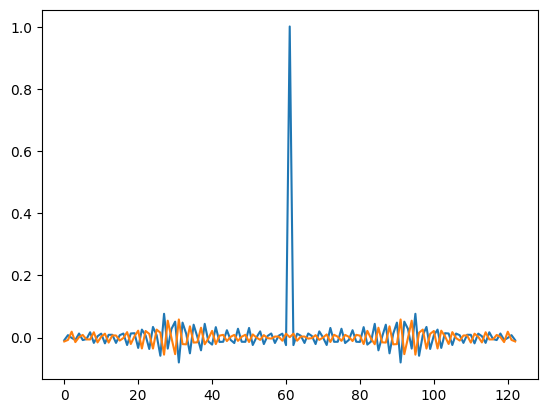

In [32]:
plt.plot(np.real(coefs_constraint))
plt.plot(np.imag(coefs_constraint))

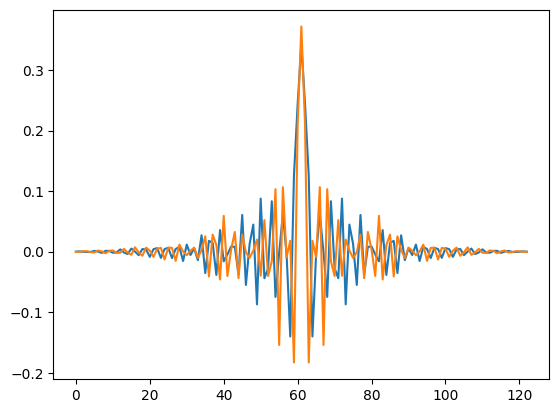

In [33]:
plt.plot(np.real(coefs_constraint_new))
plt.plot(np.imag(coefs_constraint_new))

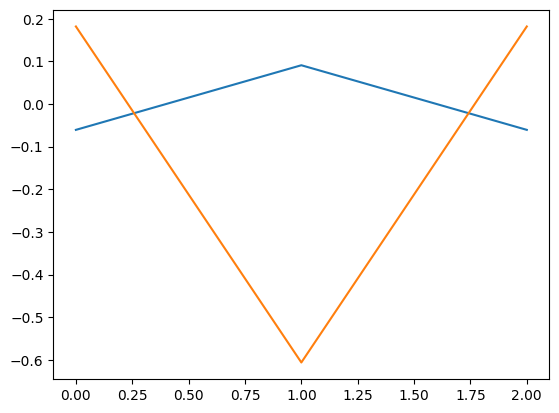

In [38]:
gammas = np.array([1.0+2.0j, 3.0+1.0j], dtype=np.complex128)
new_a, new_b = forward_nonlinear_FFT(gammas)
coefs_constraint_new = fftconvolve(new_a, np.flip(new_a), mode='full') + fftconvolve(new_b, np.flip(new_b), mode='full')
plt.plot(np.real(coefs_constraint_new))
plt.plot(np.imag(coefs_constraint_new))


## Check new function

In [15]:
np.linalg.norm(bcoeffs - new_b)

0.024081616477754295

In [16]:
np.linalg.norm(old_coeffs - new_coeffs)

0.004315824718908659

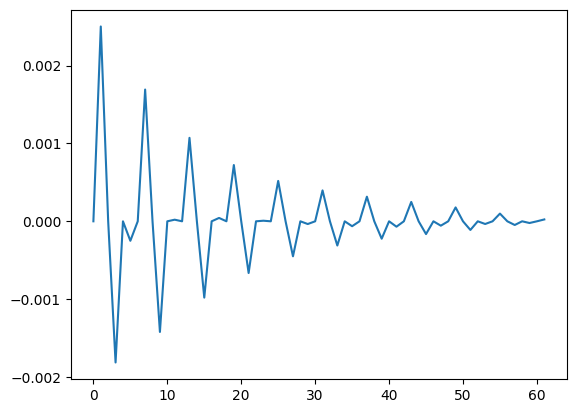

In [17]:
plt.plot(old_coeffs - new_coeffs)

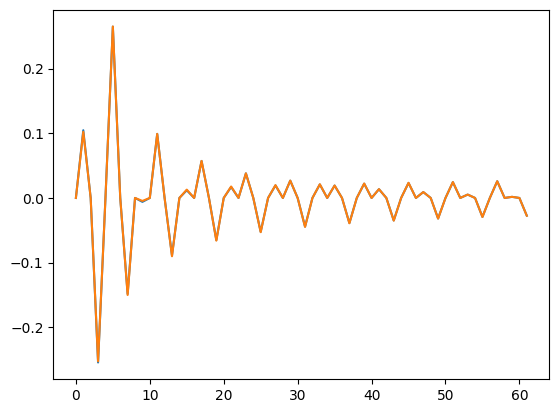

In [14]:
old_coeffs = np.zeros(len(coeffs))
old_coeffs[1::2] = 2*bcoeffs[int(len(bcoeffs)/2-1)::-1]

plt.plot(old_coeffs)
plt.plot(new_coeffs)
plt.show()

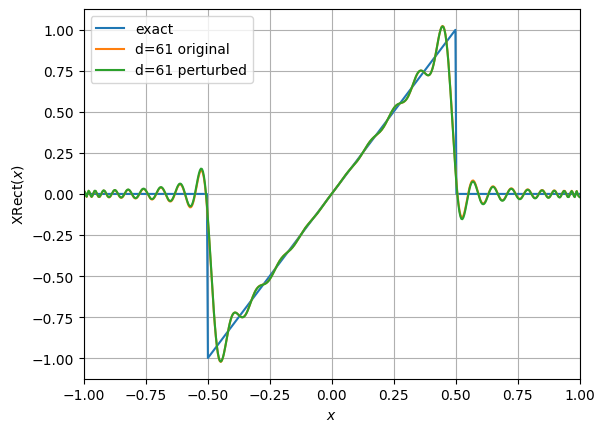

In [11]:
new_coeffs = np.zeros(len(coeffs))
new_coeffs[1::2] = 2*new_b[int(len(new_b)/2-1)::-1]

plt.grid()
plt.plot(x, y, label="exact")
plt.plot(x, cheb.chebval(x, coeffs), label=f"d={degree} original")
plt.plot(x, cheb.chebval(x, new_coeffs), label=f"d={degree} perturbed")
plt.xlim(-1, 1)
plt.xlabel(r"$x$")
plt.ylabel(r"XRect$(x)$")
plt.legend()
plt.show()

In [18]:
yvals = cheb.chebval(x, new_coeffs)
print(f"min: {min(yvals)}")
print(f"max: {max(yvals)}")

min: -1.019738171724042
max: 1.0197381717240421
